# Analysis of IMB

This notebook performs data analysis of the csv files created by running the IMB benchmark

In [13]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

In [14]:
results = {
    "Cloud_IMB":[],
    "SCARF_IMB":[],
    "JASMIN_IMB":[]
}

for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        latencyIndex = headers.index("Latency")  #
        bandwidthIndex = headers.index("0")  # after hear, all are the bandwidths
        thisMessageSizes = [int(el) for el in headers[bandwidthIndex + 1:]]
        try:
            if messageSizes != [int(el) for el in headers[bandwidthIndex + 1:]]:
                raise ValueError("Different message sizes")
        except NameError: # if messageSizes hasn't been set yet
            messageSizes = thisMessageSizes
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            thisRow["Bandwidths"] = [float(el) for el in row[bandwidthIndex + 1:]]
            thisRow["maxBandwidths"] = max(thisRow["Bandwidths"])
            thisRow["meanBandwidths"] = sum(thisRow["Bandwidths"]) / len(thisRow["Bandwidths"])
            results[dataName].append(thisRow)
print("Message Sizes:")
print(messageSizes)
print()
for dataName in results:
    print(dataName)
    print("1st latency:        {}".format(results[dataName][0]["Latency"]))
    print("max bandwidth:      {}".format(max(test["maxBandwidths"] for test in results[dataName])))
    print("1st bandwidths(10): {}".format(results[dataName][0]["Bandwidths"][0:10]))
    print("Headers:            {}".format(results[dataName][0].keys()))
    print()
        

Message Sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

JASMIN_IMB
1st latency:        0.14
max bandwidth:      11469.57
1st bandwidths(10): [6.02, 12.55, 25.1, 48.93, 99.77, 197.53, 310.68, 465.03, 876.71, 1484.06]
Headers:            dict_keys(['4096', 'Total Requested Memory (MB)', 'Exclusive', '32768', 'maxBandwidths', 'Host Groups', '8388608', '4194304', '8', 'Max Memory (MB)', '2', 'Protocols Seen', 'Max Threads', 'Bandwidths', '256', 'meanBandwidths', '2048', '16777216', '1048576', 'Hosts Used', '65536', '16384', '8192', 'Delta Memory (MB)', '512', 'CPU time (sec.)', '1', 'Max Processes', 'Number of Hosts', 'File Name', 'Latency', '131072', '32', '262144', '0', '16', 'Max Swap (MB)', '524288', '1024', '128', 'Average Memory (MB)', '4', '64', '2097152'])

SCARF_IMB
1st latency:        0.23
max bandwidth:      9149.72
1st bandwidths(10): [3.98, 7.96, 15.96, 31.86, 63.

In [15]:
import datetime

# Do cloud dates:
for result in results["Cloud_IMB"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF uppercase and map 'X-X' -> 'X'
for name in ("SCARF_IMB", "JASMIN_IMB"):
    for result in results[name]:
        result["Host Groups"] = result["Host Groups"].split("-")[0].upper()
    

['SHM', 'SHM-IBV', 'SHM-TCP']


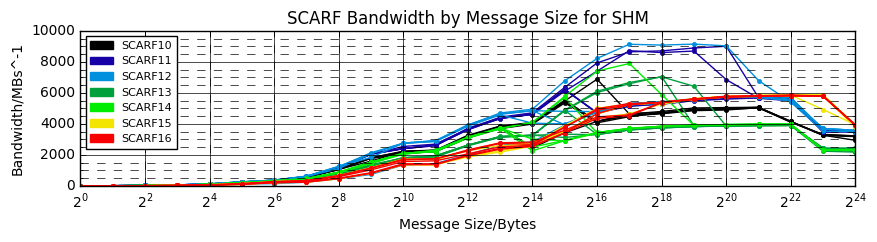

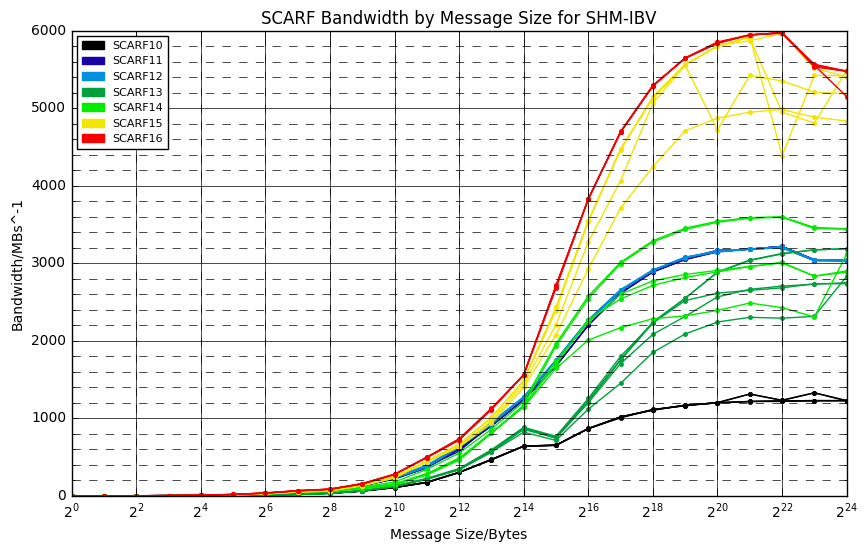

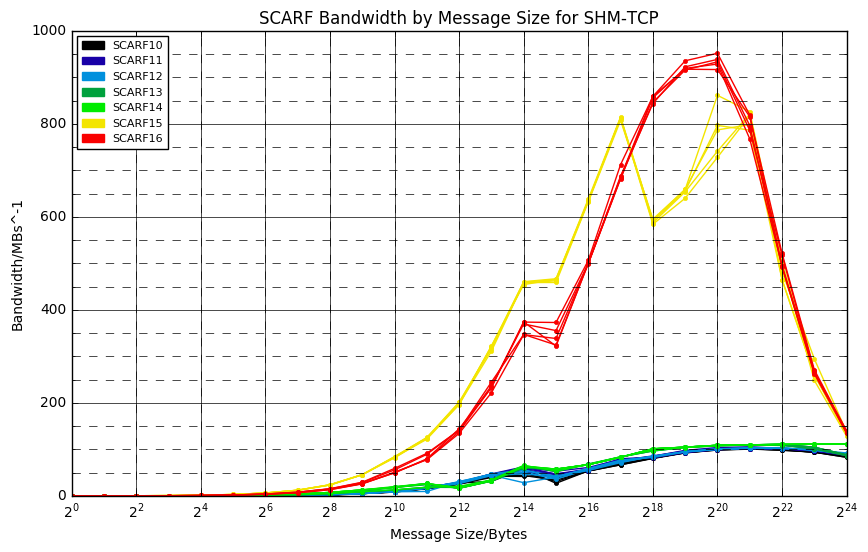

['SHM', 'SHM-TCP']


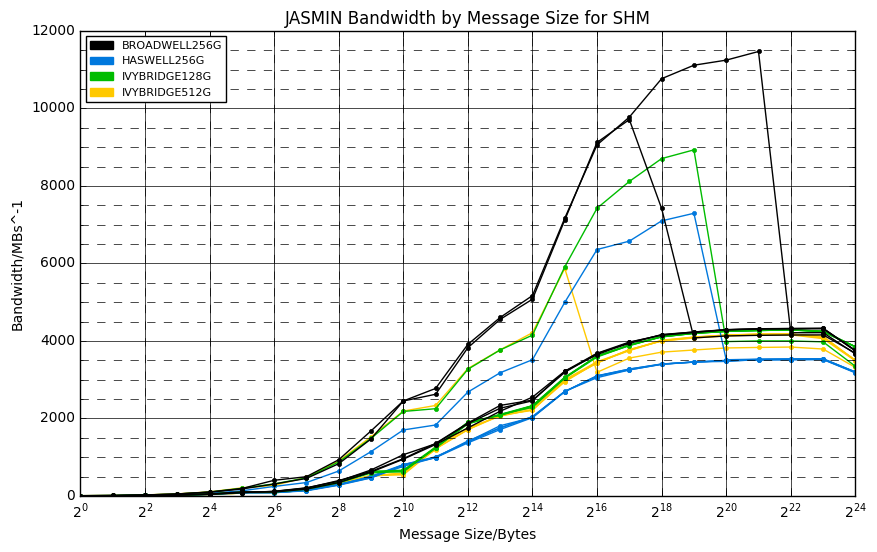

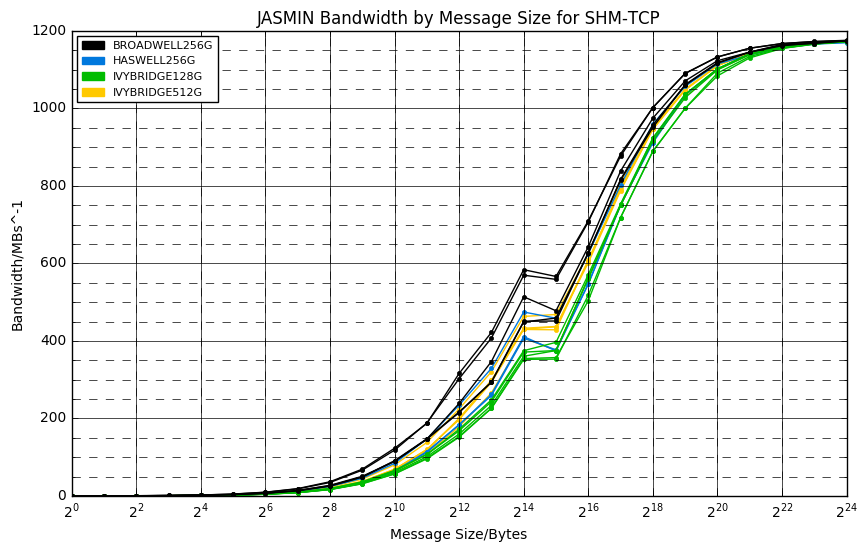

In [16]:
def plotBandwidth():
    for name in ("SCARF_IMB", "JASMIN_IMB"):
        protocols = sorted(set(row["Protocols Seen"] for row in results[name]))
        print(protocols)
        for prot in protocols:
            res = [row for row in results[name] if row["Protocols Seen"] == prot]
            hostgroups = sorted(set(row["Host Groups"] for row in res))
            clrMap = plt.get_cmap("nipy_spectral")
            legendHandles = []
            for index, hostgroup in enumerate(hostgroups):
                clr = clrMap(index / len(hostgroups))
                legendHandles.append(mpatches.Patch(color=clr, label=hostgroup))
            for index, row in enumerate(sorted(res, key=lambda el: el["File Name"])):
                band = row["Bandwidths"]
                clr = clrMap(hostgroups.index(row["Host Groups"]) / len(hostgroups))
                clr = (clr[0], clr[1], clr[2], 1)
                plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
                nodeNumbers = ",".join(re.findall("cn\d+", row["Hosts Used"]))
                # legendHandles.append(mpatches.Patch(color=clr, label=nodeNumbers))
            plt.legend(handles=legendHandles, loc=2, ncol=1, fontsize=8)
            plt.rcParams["figure.figsize"] = (10, 6)
            plt.xscale("log", basex=2)
            plt.title("{} Bandwidth by Message Size for {}".format(name.split("_")[0], prot))
            plt.xlabel("Message Size/Bytes")
            plt.ylabel("Bandwidth/MBs^-1")
            plt.grid(True, which="minor", linestyle="--")
            plt.grid(True, which="major", linestyle="-")
            plt.minorticks_on()
            plt.show()

plotBandwidth()


['1', '2']


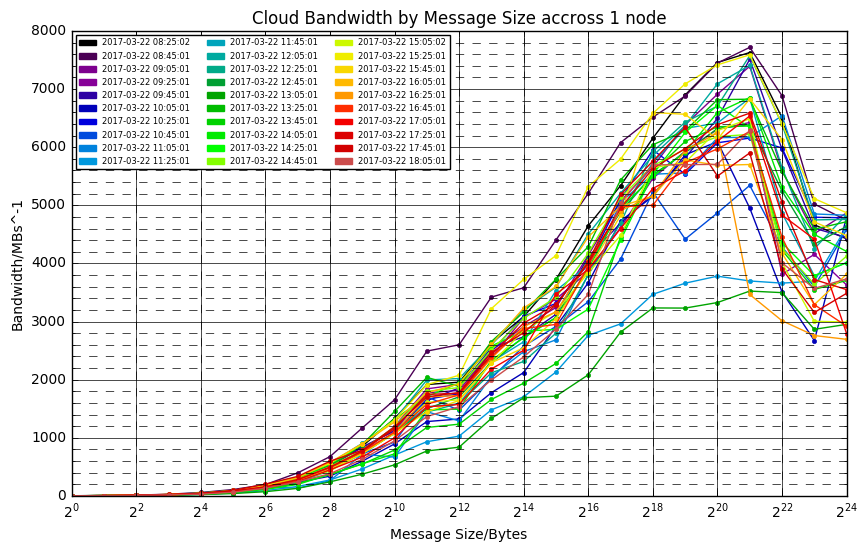

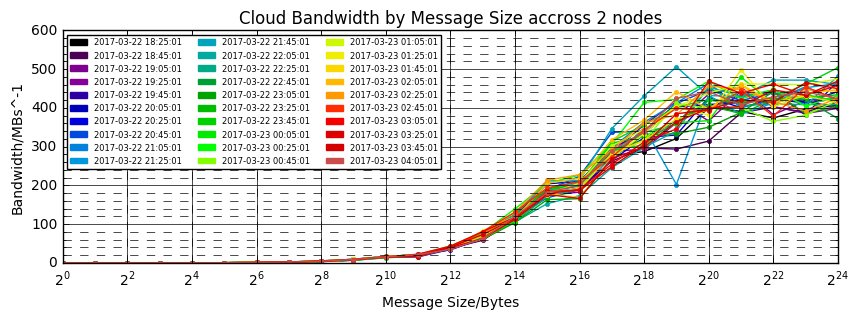

In [17]:
def plotCloudBandwidth():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    for numHosts in numHostsSet:
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        for index, row in enumerate(sorted(res, key=lambda el: el["Date Run"])):  # sort by date run
            band = row["Bandwidths"]
            clr = clrMap(index / len(res))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            legendHandles.append(mpatches.Patch(color=clr, label=row["Date Run"]))
        plt.legend(handles=legendHandles, loc=2, ncol=3, fontsize=6)
        plt.rcParams["figure.figsize"] = (10, 3)
        plt.xscale("log", basex=2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Cloud Bandwidth by Message Size accross " + titleEnd)
        plt.xlabel("Message Size/Bytes")
        plt.ylabel("Bandwidth/MBs^-1")
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotCloudBandwidth()

['1', '2']


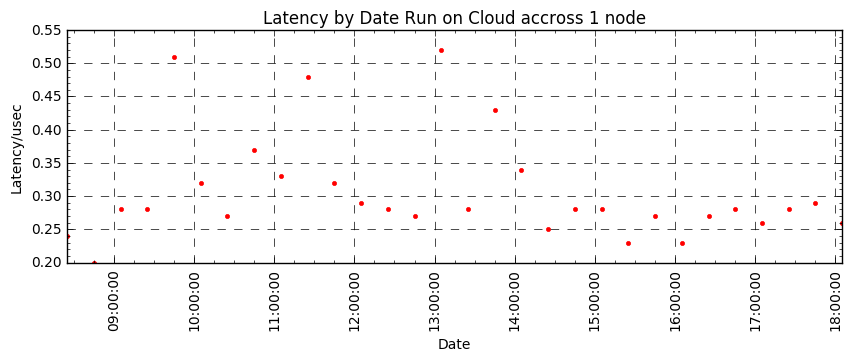

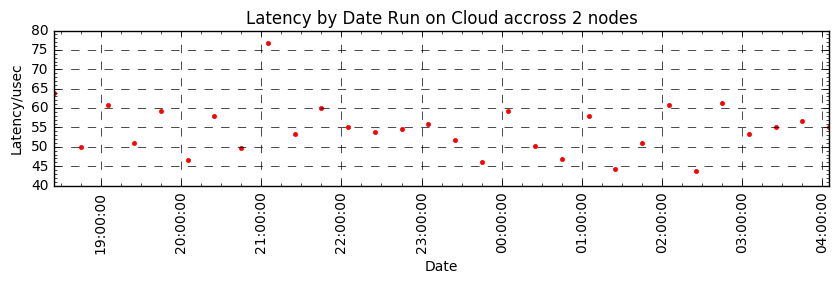

In [18]:
def plotCloudLatencies():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    
    for index, numHosts in enumerate(numHostsSet):
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        plt.plot([row["Date Run"] for row in res], 
                 [row["Latency"] for row in res], "r.")
        plt.xticks(rotation='vertical')
        plt.rcParams["figure.figsize"] = (10,2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Latency by Date Run on Cloud accross " + titleEnd)
        plt.ylabel("Latency/usec")
        plt.xlabel("Date")
        #plt.grid(True, which="minor", linestyle="-")
        plt.grid(True, which="major", linestyle="--")
        plt.minorticks_on()
        plt.show()

plotCloudLatencies()

{'SHM-IBV': [0.0, 1270.664, 3215.99, 3207.532, 2940.256, 3267.558, 5670.066, 5975.284000000001, 0.0, 0.0, 0.0, 0.0], 'SHM': [6504.270333333332, 5649.492, 7278.755999999999, 6456.706, 5362.611999999999, 5109.788, 5853.468, 5833.407999999999, 6829.466, 4281.682, 5214.799999999999, 4513.022], 'SHM-TCP': [456.4193333333333, 101.54199999999999, 103.09, 102.912, 110.51200000000001, 111.814, 825.884, 934.164, 1174.9099999999999, 1170.8066666666666, 1172.7040000000002, 1172.762]}
12 12
12 12
12 12


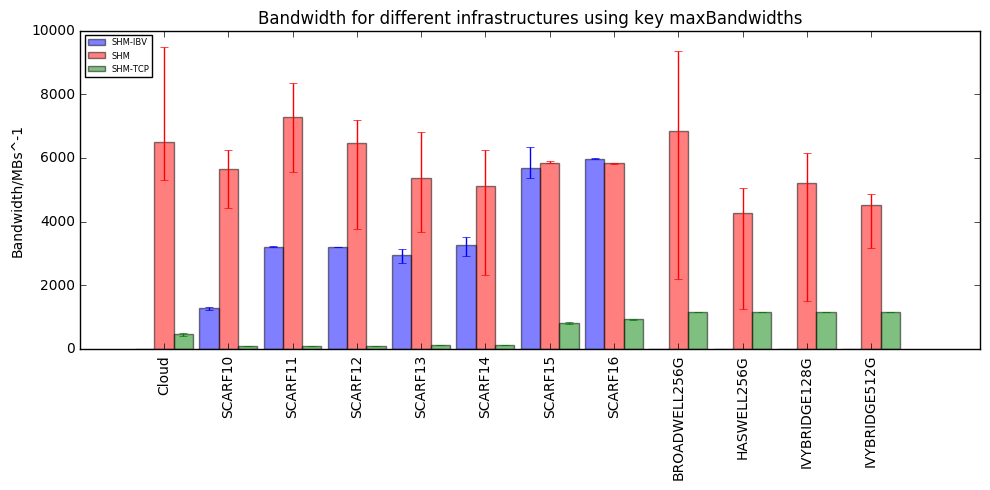

{'SHM-IBV': [0.0, 514.12312, 1273.50368, 1283.4437599999999, 975.6043999999999, 1251.12, 2038.06024, 2219.58032, 0.0, 0.0, 0.0, 0.0], 'SHM': [2401.6685599999996, 2554.24248, 3183.8079999999995, 3006.02088, 2205.79592, 2219.4944, 2581.0888800000002, 2568.18128, 2696.6012, 1842.8022400000002, 2200.45568, 1983.47952], 'SHM-TCP': [151.0542533333333, 38.51232, 40.977920000000005, 40.21048, 44.18784, 46.03248000000001, 276.28616, 275.16744, 454.2584800000001, 425.814, 412.06448, 430.22672]}
12 12
12 12
12 12


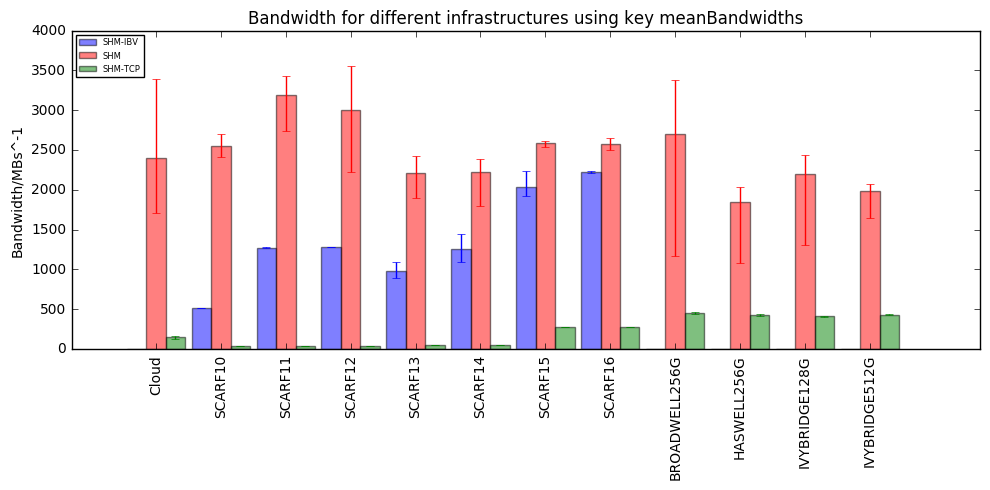

{'SHM-IBV': [0.0, 468.494, 913.838, 935.6600000000001, 579.1139999999999, 822.4159999999999, 988.2639999999999, 1122.5120000000002, 0.0, 0.0, 0.0, 0.0], 'SHM': [2331.777, 3797.7880000000005, 4377.582, 4235.566000000001, 3169.752, 3722.488, 2514.7339999999995, 2571.37, 3189.5299999999997, 2043.5700000000002, 2428.022, 2413.5860000000002], 'SHM-TCP': [70.81533333333333, 39.924, 45.962, 45.632, 32.814, 33.336, 318.38, 233.964, 352.73400000000004, 283.50333333333333, 235.512, 295.25]}
12 12
12 12
12 12


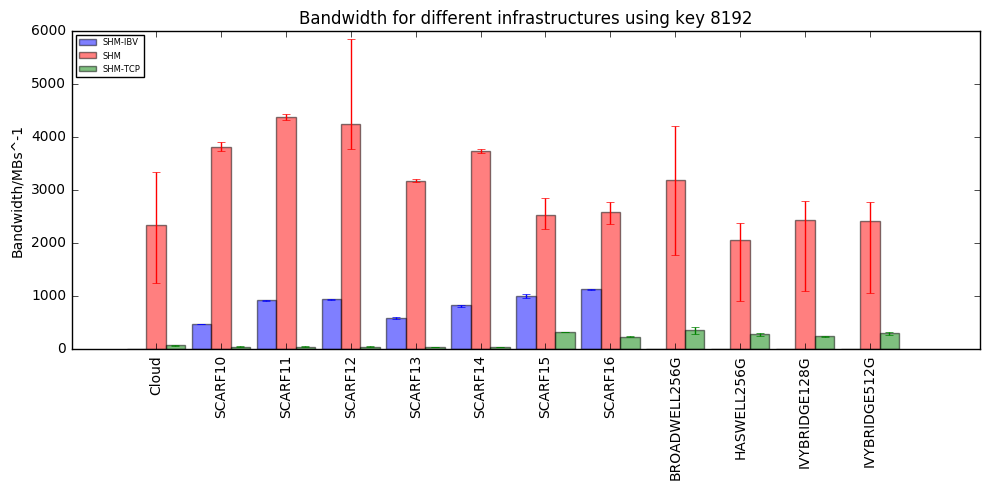

{'SHM-IBV': [0.0, 109.43200000000002, 225.25799999999998, 234.96599999999998, 123.09, 154.324, 243.07, 278.32000000000005, 0.0, 0.0, 0.0, 0.0], 'SHM': [1086.0096666666666, 2178.1340000000005, 2435.85, 2475.622, 1778.56, 2078.954, 1580.918, 1556.18, 1574.81, 975.1540000000001, 949.8100000000001, 895.598], 'SHM-TCP': [15.578333333333331, 8.902000000000001, 9.632, 9.297999999999998, 16.312, 17.758000000000003, 83.44, 53.178, 102.116, 70.90333333333332, 60.846000000000004, 69.32000000000001]}
12 12
12 12
12 12


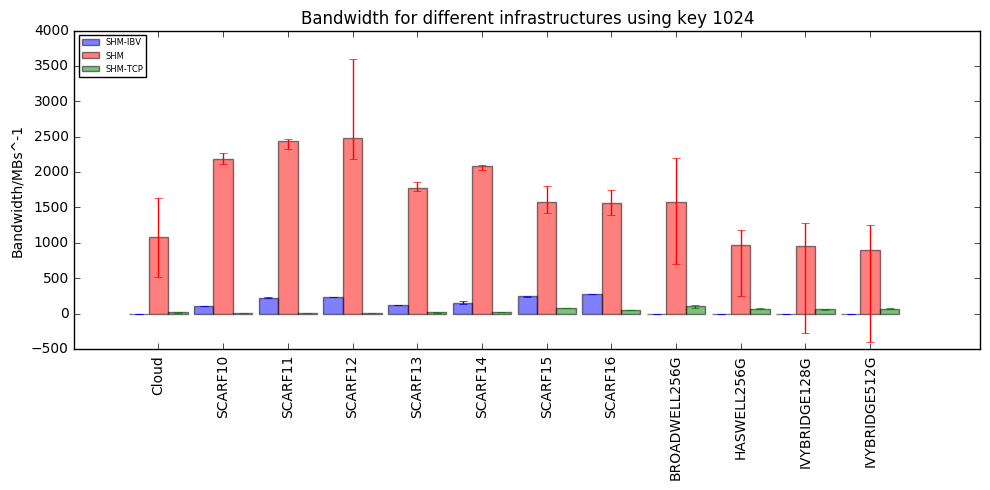

In [41]:
def plotBandwidths(BW_KEY="maxBandwidths"):
    
    clrs = {"SHM": "r", "SHM-TCP":"g", "SHM-IBV":"b"}
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues = ["Cloud"]
    
    
    # Add the SCARF and JASMIN data split into host group and number of hosts
    for name in ("SCARF_IMB", "JASMIN_IMB"):
        for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
            xValues += [hostgroup]
            for prot in clrs.keys():
                thisData = [row[BW_KEY] for row in results[name] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]]
                if len(thisData) == 0:  # if no data then there is a divide by zero so send this (mostly IBV)
                    addBarData([0], prot)
                else:
                    addBarData(thisData, prot)
    print(yValues)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.3
    
    for i, (label, yVals) in enumerate(yValues.items()):
        print(len(yValues[label]), len(index))
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.5, label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yTopError[label], yBottomError[label]], linestyle=" ", 
                     color=clrs[label])
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Bandwidth/MBs^-1")
    # plt.yscale("log")
    plt.title('Bandwidth for different infrastructures using key {}'.format(BW_KEY))

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()
    


plotBandwidths()
plotBandwidths(BW_KEY="meanBandwidths")
plotBandwidths(BW_KEY="8192")
plotBandwidths(BW_KEY="1024")

In [ ]:
def plotLatencies(L_KEY="Latency"):
    
    
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[L_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[L_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues = ["Cloud"]
    
    
    # Add the SCARF split into host group and number of hosts
    
    for hostgroup in sorted(set(row["Host Groups"] for row in results["SCARF_IMB"])):
        xValues += [hostgroup]
        for prot in sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"])):
            addBarData([row[L_KEY] for row in results["SCARF_IMB"] 
                        if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]], prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.3
    clrs = ["r", "g", "b"]
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yValues[label], bar_width, align='center', color=clrs[i], alpha=0.5, label=label)
        plt.errorbar(index + i * bar_width, yValues[label], yerr=[yTopError[label], yBottomError[label]], linestyle=" ", 
                     color=clrs[i])
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Latency/usec")
    #plt.yscale("log")
    plt.title('Latency for different infrastructures')

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()

plotLatencies()

In [ ]:
len()